In [1]:
import os
import cv2
import PIL.Image as Image
from PIL import Image
import matplotlib.image as  mpimg
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

In [2]:
gpu_bool = torch.cuda.is_available()
gpu_bool

True

In [3]:
#!unzip  /content/drive/My\ Drive/Resized_Img_Mask.zip 
#!unzip  Resized_Img_Mask.zip 

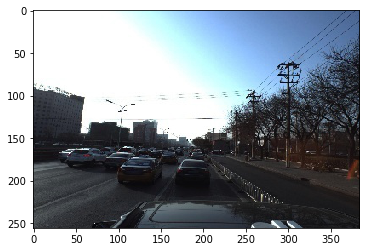

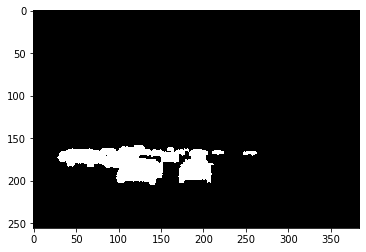

In [4]:
file1 = 'Resized_Img_Mask/4/image.jpg'
file2 = 'Resized_Img_Mask/4/mask.png'
img = plt.imread(file1)
mask = plt.imread(file2)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(mask)
#print(mask[180,:,1])

In [29]:
# TODO: Design your own dataset
def convertMask(masks):
  """this function get the mask tensor (batchsize, 1, H, W) and returns a target tensor 
  with dimension (batchsize, 2, H, W), which is a ground truth probability.
  2 is the class number
  """
  return torch.cat(((masks == 0).float(),(masks == 255).float()), 0)

class ImageDataset(Dataset):
    def __init__(self, input_dir, transform = None):
      self.input_dir = input_dir
      self.transform = transform
      self.trans = transforms.ToTensor()
      self.image = []
      self.mask = []
      self.num = [] # the number of active channel
    def transformation(self, images, masks):
      if torch.randperm(2)[0]:
        images = TF.hflip(images)
        masks = TF.hflip(masks)
      if torch.randperm(2)[0]:
        images = TF.vflip(images)
        masks = TF.vflip(masks)
      
      return self.trans(images), self.trans(masks)*255

    def __len__ (self):
        return sum([str.isdigit(s) for s in os.listdir(self.input_dir)])

    def __getitem__(self, idx):
      path_image = self.input_dir + str(idx) + "/"+'image.jpg'
      #print(path_image)
      path_mask = self.input_dir + str(idx) + "/"+'mask.png'
      if os.path.exists(path_image) and os.path.exists(path_mask):
        self.image = Image.open(path_image)
        self.mask = Image.open(path_mask)

      if self.transform:
        self.image, self.mask = self.transformation(self.image, self.mask)
        #print(self.mask.shape)
      else:
        self.image = self.trans(self.image)
        self.mask = (self.trans(self.mask)*255).long()
      #print(mask.shape)
      self.mask = self.mask[0,:,:].reshape(1,256,384)
      #print(self.mask.shape)

      self.mask = convertMask(self.mask)
      #print(self.mask.shape)
      self.num = torch.sum((torch.sum(self.mask, (1,2)) != 0))

      return self.image, self.mask, self.num 

train_batch_size = 10
train_path = 'Resized_Img_Mask/'
train_dataset = ImageDataset(train_path, transform=False)
a, b, c= train_dataset[0][0], train_dataset[0][1], train_dataset[0][2]
print(a.shape,b.shape)
#print(b[1,180,:])

print(c)


torch.Size([3, 256, 384]) torch.Size([2, 256, 384])
tensor(2)


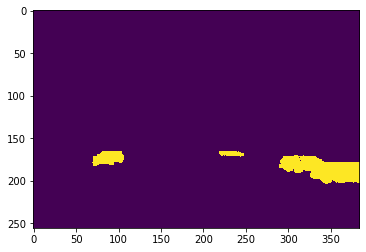

In [32]:
plt.imshow(b[1,:,:])

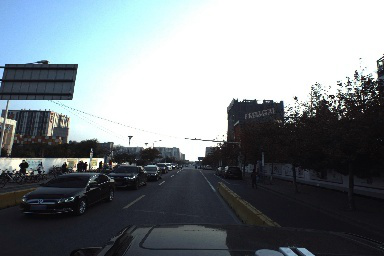

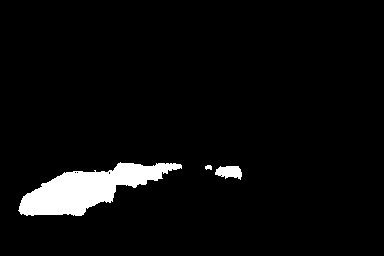

tensor(2)


In [33]:
#make sure the data has been flipped
a, b, c= train_dataset[17][0], train_dataset[17][1], train_dataset[17][2]
#print the image
img1 = transforms.ToPILImage()(a).convert("RGB")
display(img1)
#print the mask
img2 = transforms.ToPILImage()(b[1])
display(img2)
#print the num
print(c)

In [8]:
def MakePrediction(output):
  """this function get the model output tensor (batchsize, 8, H, W) (without softmax) and returns a prediction tensor
  with dimension (batchsize, 2, H, W), with values of 0 or 1.
  2 is the class number
  """
  softmax = nn.Softmax(dim=1)
  _,d = torch.max(softmax(output), 1, keepdim = True)
  return torch.cat(((d == 0).float(),(d == 1).float()), 1)

def Accuracy(pred, target):
  #consider all channels, including the non_active ones
  #target is ground truth label
  #pred is prediction (the output from the MakePrediction)
  batch_size, num_class, H, W = pred.shape
  Accuracy_batch = 0
  for i in range(batch_size):#for each example
    a = pred[i, :, :, :].float()
    b = target[i, :, :, :].float()
    Accuracy_channel = 0
    for j in range(num_class):#for each channel
      Accuracy_channel += torch.sum((torch.abs(a[j, :, :] - b[j, :, :]) < 1E-9).float())/H/W
    Accuracy_batch += Accuracy_channel / num_class
  Accuracy_batch /= batch_size
  return Accuracy_batch

def DiceScore_activeonly(pred, target, num):
  #we donnot consider the non-active channel
  #target is ground truth label
  #pred is prediction (the output from the MakePrediction)
  #num is the number of of active channels  (batch_size X )1, this is a constant number given the example
  batch_size, num_class, H, W = pred.shape
  alpha = 0.0001
  Dice_batch = 0
  for i in range(batch_size):#for each example
    Dice_channel = 0
    for j in range(num_class):#for each channel
      a = torch.sum(pred[i,j] * target[i,j])
      b = torch.sum(pred[i,j] + target[i,j])
      weight = a/(num[i]*a + alpha)#weight is 0 if the channel is not active (a = 0), weight = 1/num(i) if the channel is active
      Dice_channel += ((2*a)/(b + alpha))*weight
    Dice_batch += Dice_channel

  return Dice_batch/batch_size

class DICELoss(nn.Module):
  def __init__(self, batch_size = 10, class_num = 2, epilson = 0.0001):
      super(DICELoss, self).__init__()
      self.BS = batch_size
      self.Classnum = class_num
      self.epilson = epilson

  def forward(self, output, target, num):
    loss_batch = 0
    #pass the output from the unet through a softmax
    softmax = nn.Softmax(dim=1)
    output = softmax(output)
    for i in range(self.BS): #for each example
      loss_channel = 0
      for j in range(self.Classnum): #for each channel
        #calculate the loss for each channel:
        a = torch.sum(output[i,j] * target[i,j])
        b = torch.sum(output[i,j] + target[i,j])
        weight = a/(num[i]*a + self.epilson)
        loss_channel += (1 - (2*a + self.epilson)/(b + self.epilson))*weight

      loss_batch += loss_channel

    return loss_batch/self.BS


def DiceScore_all_channel(pred, target, num):
  #we donnot consider the non-active channel
  #target is ground truth label
  #pred is prediction (the output from the MakePrediction)
  #num is the number of of active channels  (batch_size X )1, this is a constant number given the example
  batch_size, num_class, H, W = pred.shape
  alpha = 0.0001
  Dice_batch = 0
  for i in range(batch_size):#for each example
    Dice_channel = 0
    for j in range(num_class):#for each channel
      a = torch.sum(pred[i,j] * target[i,j])
      b = torch.sum(pred[i,j] + target[i,j])
      Dice_channel += ((2*a + alpha)/(b + alpha))/num_class
    Dice_batch += Dice_channel

  return Dice_batch/batch_size

class DICELoss_all_channel(nn.Module):
  def __init__(self, batch_size = 10, class_num = 2, epilson = 20000):
      super(DICELoss_all_channel, self).__init__()
      self.BS = batch_size
      self.Classnum = class_num
      self.epilson = epilson

  def forward(self, output, target, num):
    loss_batch = 0
    #pass the output from the unet through a softmax
    softmax = nn.Softmax(dim=1)
    output = softmax(output)
    for i in range(self.BS): #for each example
      loss_channel = 0
      for j in range(self.Classnum): #for each channel
        #calculate the loss for each channel:
        a = torch.sum(output[i,j] * target[i,j])
        b = torch.sum(output[i,j] + target[i,j])
        loss_channel += (1 - (2*a + self.epilson)/(b + self.epilson))/self.Classnum

      loss_batch += loss_channel

    return loss_batch/self.BS




In [9]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    # Use batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out,),
      nn.LeakyReLU(0.1)
    )
  else:
    # No batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

# Upsampling
def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )


# U-Net
class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1 = add_conv_stage(3, 32, useBN=useBN)
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    #TODO: Design your last layer & activations
    self.conv4m= add_conv_stage(32, 32, useBN=useBN)
    self.conv_Final = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)

    # weight initialization
    # You can have your own weight intialization. This is just an example.
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out  = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out  = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out  = self.conv1m(conv2m_out_)
     
    conv1m_out = self.conv4m(conv1m_out)
    onv1m_out = self.conv4m(conv1m_out)

    output = self.conv_Final(conv1m_out)
 
    return output



In [10]:
def training_step(model):
  model.train()
  #form the random index
  index = torch.randperm(len(train_dataset))[:train_batch_size].data.numpy()
  
  #get the first index
  image_batch = train_dataset[index[0]][0].reshape(1, 3, 256, 384)
  label_batch = train_dataset[index[0]][1].reshape(1, 2, 256, 384)
  num_batch = train_dataset[index[0]][2].reshape(1,1)
  for i in range(len(index)-1):
    a = train_dataset[index[i+1]][0].reshape(1, 3, 256, 384)
    b = train_dataset[index[i+1]][1].reshape(1, 2, 256, 384)
    c = train_dataset[index[i+1]][2].reshape(1, 1)
    image_batch = torch.cat((image_batch, a), dim = 0)
    label_batch = torch.cat((label_batch, b), dim = 0)
    num_batch = torch.cat((num_batch, c), dim = 0)

  if gpu_bool:
    image_batch = image_batch.cuda()
    label_batch = label_batch.cuda()
    num_batch = num_batch.cuda() 
   
  optimizer.zero_grad()
  output = model(image_batch)
  loss = train_loss(output, label_batch, num_batch)

  loss.backward()
  optimizer.step()
  scheduler.step()

  pred = MakePrediction(output)
  #print(pred.shape)

  return loss, DiceScore_activeonly(pred, label_batch, num_batch), Accuracy(pred, label_batch)

def val_step(model):
  model.eval()
  #form the random index
  index = torch.randperm(len(val_dataset))[:validation_batch_size].data.numpy()
  #get the first index
  image_batch = val_dataset[index[0]][0].reshape(1, 3, 256, 384)
  label_batch = val_dataset[index[0]][1].reshape(1, 2, 256, 384)
  num_batch = val_dataset[index[0]][2].reshape(1,1)
  for i in range(len(index)-1):
    a = val_dataset[index[i+1]][0].reshape(1, 3, 256, 384)
    b = val_dataset[index[i+1]][1].reshape(1, 2, 256, 384)
    c = val_dataset[index[i+1]][2].reshape(1, 1)
    image_batch = torch.cat((image_batch, a), dim = 0)
    label_batch = torch.cat((label_batch, b), dim = 0)
    num_batch = torch.cat((num_batch, c), dim = 0)

  if gpu_bool:
    image_batch = image_batch.cuda()
    label_batch = label_batch.cuda()
    num_batch = num_batch.cuda() 
    
  output = model(image_batch)
  vali_loss = val_loss(output, label_batch, num_batch)

  pred = MakePrediction(output)

  return vali_loss, DiceScore_activeonly(pred, label_batch, num_batch), Accuracy(pred, label_batch)

In [23]:
######################## Hyperparameters #################################

# Batch size can be changed if it does not match your memory, please state your batch step_size in your report.
input_channel = 3
output_channel = 2
H = 256
W = 384

train_batch_size = 20
validation_batch_size = 20

train_path = 'Resized_Img_Mask/'
train_dataset = ImageDataset(train_path, transform=False)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

val_path = 'Resized_Img_Mask/'
val_dataset = ImageDataset(val_path, transform=False)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=train_batch_size)

# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 30

model_Q1a = unet(useBN=True)
if gpu_bool:
    model_Q1a = model_Q1a.cuda()

optimizer = torch.optim.RMSprop(model_Q1a.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)



#define the loss function
#train_loss = DICELoss(batch_size = train_batch_size)#train_batch_size, output_channel)
#val_loss = DICELoss(batch_size = validation_batch_size)#validation_batch_size, output_channel)
train_loss = DICELoss_all_channel(batch_size = train_batch_size)#train_batch_size, output_channel)
val_loss = DICELoss_all_channel(batch_size = validation_batch_size)#validation_batch_size, output_channel)


#initialize the weight
def weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv2d') != -1 or classname.find('Linear') != -1:
      #print(classname.find('Conv2d'),classname.find('Linear'))
      torch.nn.init.xavier_uniform_(m.weight.data)
model_Q1a.apply(weights_init)


info_train = []
info_val = []

print("Start Training...")
#fig = plt.figure()
for epoch in range(num_epochs):
  print("Epoch:", epoch)
  #training step
  tra_loss, tra_dice, tra_accuracy = training_step(model_Q1a)#, image_batch, label_batch)
  print(tra_loss.item(), tra_dice.item(), tra_accuracy.item())

  #validation step
  with torch.no_grad():
    vali_loss, vali_dice, val_accuracy = val_step(model_Q1a)
    print(vali_loss.item(), vali_dice.item(), val_accuracy.item())


  # if epoch%10 == 0:
  #   print("Trainning loss/dice: " + str(tra_loss.item()) + ', ' + str(tra_dice.item()))
  #   print("Validation loss/dice: " + str(vali_loss.item())+ ', ' + str(vali_dice.item()) + "\n")
  
  #save the data
  info_train.append([epoch, tra_loss.item(), tra_dice.item(), tra_accuracy.item()])
  info_val.append([epoch, vali_loss.item(), vali_dice.item(), val_accuracy.item()])

Start Training...
Epoch: 0
0.4653394818305969 0.4119322896003723 0.608478307723999
0.8009193539619446 0.03535158932209015 0.03726603463292122
Epoch: 1
0.3241349458694458 0.4805161654949188 0.785549521446228
0.8011070489883423 0.03511367365717888 0.03679606318473816
Epoch: 2
0.260254830121994 0.45344242453575134 0.8155716061592102
0.10847264528274536 0.48630690574645996 0.9473379254341125
Epoch: 3
0.16349512338638306 0.4899800419807434 0.9609736800193787
0.10672961920499802 0.49093151092529297 0.9646027684211731
Epoch: 4
0.11983611434698105 0.48807844519615173 0.9538934826850891
0.17491787672042847 0.48935791850090027 0.9586624503135681
Epoch: 5
0.12237954139709473 0.4884065091609955 0.9550690054893494
0.11509698629379272 0.4880278706550598 0.953711986541748
Epoch: 6
0.08885624259710312 0.4903879165649414 0.9625563621520996
0.0889844000339508 0.4922668933868408 0.9696411490440369
Epoch: 7
0.08231456577777863 0.4905199706554413 0.9634156227111816
0.10626351088285446 0.4890473484992981 0.

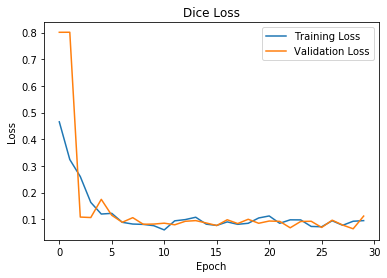

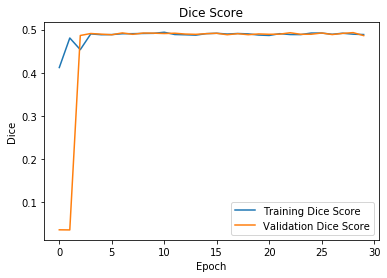

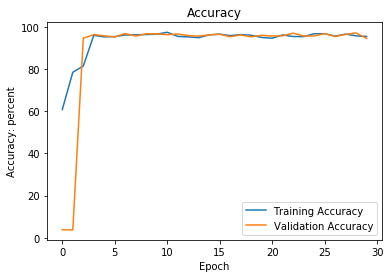

In [24]:
#visualize the data
data_train = np.array(info_train)
data_val = np.array(info_val)
#plot the dice loss
plt.figure()
Dice_train, = plt.plot(data_train[:,0], data_train[:,1], label='Training Loss')
Dice_val, = plt.plot(data_val[:,0], data_val[:,1], label='Validation Loss')
plt.title("Dice Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(handles=[Dice_train, Dice_val])
#plot the dice score
plt.figure()
Dice_train, = plt.plot(data_train[:,0], data_train[:,2], label='Training Dice Score')
Dice_val, = plt.plot(data_val[:,0], data_val[:,2], label='Validation Dice Score')
plt.title("Dice Score")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend(handles=[Dice_train, Dice_val])

#plot the accuracy
plt.figure()
Dice_train, = plt.plot(data_train[:,0], data_train[:,3]*100, label='Training Accuracy')
Dice_val, = plt.plot(data_val[:,0], data_val[:,3]*100, label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy: percent")
plt.legend(handles=[Dice_train, Dice_val])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Text(0.5, 1.0, 'Ground Truth')

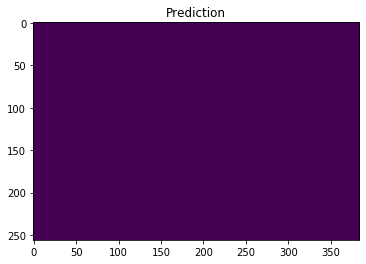

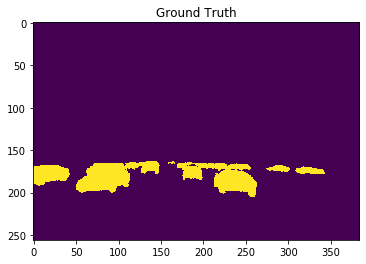

In [28]:
import matplotlib.pyplot as plt

img = train_dataset[2][0].reshape(1,3,256,384).cuda()
label = (train_dataset[2][1]).cuda().reshape(1,2,256,384)
num = (train_dataset[2][2]).cuda()
#print(img.shape, label.shape, num)

output = model_Q1a(img)
pred = MakePrediction(output)
#print(pred.shape, pred.min())
print(pred[0,1,:,100])
accuracy = Accuracy(pred, label)
print(accuracy.item())
plt.figure()
plt.imshow((pred[0,0,:,:]).cpu().numpy())
plt.title("Prediction")
plt.figure()
plt.imshow(label[0,1,:,:].cpu().numpy())
plt.title("Ground Truth")

